In [58]:
import pandas as pd 
import numpy as np 

# 1. Read in and understand the data 

In [453]:
df = pd.read_csv('data/morningstar_data.csv', index_col = 0)
df.drop(df.filter(regex='Unnamed').columns, axis=1, inplace = True)
df.drop(df[df['asofdate'] < '2020-10-01'].index, inplace = True)
# at 2021-07-06, the fund has a change in name 
df.replace({'Ivy High Income I':'Delaware Ivy High Income Fund Class I' }, inplace = True)

In [454]:
df.columns

Index(['year', 'mon', 'asofdate', 'universe', 'id', 'name', 'cusip',
       'CUSIP_hold', 'isin', 'securityname', 'numberofshare', 'marketvalue',
       'weighting', 'RTG_MOODY', 'RTG_SP', 'CUST_TRR_RETURN_HOLDING_PER',
       'SECURITY_TYP', 'INDUSTRY_SECTOR', 'INDUSTRY_GROUP'],
      dtype='object')

In [455]:
df.head(3)

,year,mon,asofdate,universe,id,name,cusip,CUSIP_hold,isin,securityname,numberofshare,marketvalue,weighting,RTG_MOODY,RTG_SP,CUST_TRR_RETURN_HOLDING_PER,SECURITY_TYP,INDUSTRY_SECTOR,INDUSTRY_GROUP
0,2021,8,2021-08-04,FO,FOUSA02UWB,T. Rowe Price Instl High Yield,77958B204,76105Y109,US76105Y1091,T. Rowe Price Gov. Reserve,43331194.0,43331194,2.07,#N/A Field Not Applicable,#N/A Field Not Applicable,9.758829,Open-End Fund,Funds,Money Market Fund
1,2022,1,2022-01-05,FO,FOUSA02UWB,T. Rowe Price Instl High Yield,77958B204,76105Y109,US76105Y1091,T. Rowe Price Gov. Reserve,43457649.0,43457649,1.99,#N/A Field Not Applicable,#N/A Field Not Applicable,10.87345,Open-End Fund,Funds,Money Market Fund
2,2021,7,2021-07-06,FO,FOUSA02UWB,T. Rowe Price Instl High Yield,77958B204,76105Y109,US76105Y1091,T. Rowe Price Gov. Reserve,23383016.0,23383016,1.16,#N/A Field Not Applicable,#N/A Field Not Applicable,9.909167,Open-End Fund,Funds,Money Market Fund


In [456]:
print(len(pd.unique(df.name)))
print(pd.unique(df.name))

23
['T. Rowe Price Instl High Yield' 'Western Asset High Yield IS'
 'Delaware Ivy High Income Fund Class I' 'AB High Income Advisor'
 'Strategic Advisers® Income Opportunities'
 'Federated Hermes Instl High Yield Bd IS' 'Putnam High Yield A'
 'JPMorgan High Yield I' 'American Funds American High-Inc A'
 'Columbia High Yield Bond A' 'BlackRock High Yield Bond Instl'
 'Goldman Sachs High Yield Instl' 'PGIM High Yield A'
 'Invesco High Yield A' 'TIAA-CREF High-Yield Inst'
 'PIMCO High Yield Instl' 'Vanguard High-Yield Corporate Adm'
 'Neuberger Berman High Income Bond Instl' 'Lord Abbett High Yield I'
 'Fidelity Advisor® High Income Advtg I' 'Fidelity® Capital & Income'
 'Franklin High Income A1' 'Payden High Income']


In [457]:
# no data for jpmorgan high yield I
df[df['CUST_TRR_RETURN_HOLDING_PER']== '#N/A Invalid Security']
df.replace('#N/A Invalid Security', np.nan, inplace = True)

In [458]:
# the data comes in monthly
pd.unique(sorted(df.asofdate))

array(['2020-10-05', '2020-11-04', '2020-12-03', '2021-01-06',
       '2021-02-03', '2021-03-03', '2021-04-06', '2021-05-05',
       '2021-06-03', '2021-07-06', '2021-08-04', '2021-09-03',
       '2021-10-05', '2021-11-03', '2021-12-03', '2022-01-05',
       '2022-02-03'], dtype=object)

In [508]:
df['asofdate'] = df['asofdate'].astype('datetime64[ns]')
df['cusip'] = df['cusip'].astype('string')

# 2. visuals 

## 2.1. how particular funds are evovling are changing overtime 

In [460]:
import seaborn as sns 
from matplotlib import pyplot as plt 

In [463]:
a = (df[['asofdate','name', 'CUST_TRR_RETURN_HOLDING_PER']]
    .groupby(['name'], sort=False) \
    .apply(lambda x: x.sort_values(['asofdate'], ascending=True)) \
    .reset_index(drop=True)
    .drop_duplicates())
a = a.astype({'CUST_TRR_RETURN_HOLDING_PER':'float'})
a.dtypes

asofdate                       datetime64[ns]
name                                   object
CUST_TRR_RETURN_HOLDING_PER           float64
dtype: object

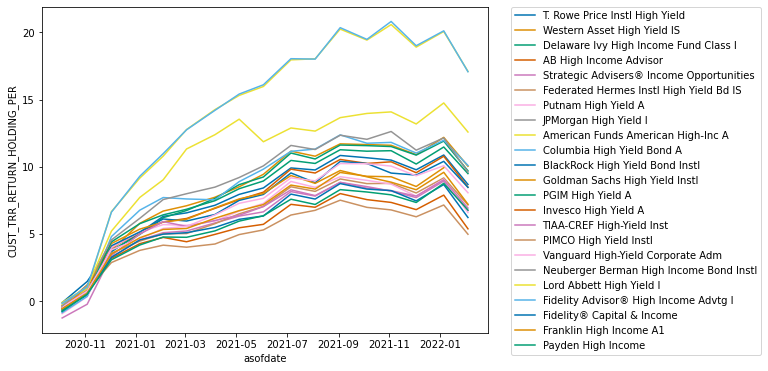

In [467]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=a, x="asofdate", y="CUST_TRR_RETURN_HOLDING_PER", hue="name", palette='colorblind')
sns.color_palette("colorblind")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# inv

### some thoughts: breakup the at each time point, the delta in fund performance, and then find how the positions of those funds have changed, and what holdings are persistent 

In [468]:
return_diff = pd.DataFrame(a.sort_values('asofdate').groupby(['name'])['CUST_TRR_RETURN_HOLDING_PER'].diff()).rename(columns={'CUST_TRR_RETURN_HOLDING_PER':'return_diff'})
a = a.merge(return_diff, left_index = True, right_index = True)


In [469]:
# rank by delta from large to small (positive > negative), essentially, we are finding the relatively best performing funds 
a["rank"] = a.groupby("asofdate")["return_diff"].rank("dense", ascending=False)

In [470]:
a.head(5)

,asofdate,name,CUST_TRR_RETURN_HOLDING_PER,return_diff,rank
0,2020-10-05,T. Rowe Price Instl High Yield,-0.440435,NaN,NaN
571,2020-11-04,T. Rowe Price Instl High Yield,0.392034,0.832469,22.0
1182,2020-12-03,T. Rowe Price Instl High Yield,3.668413,3.276379,9.0
1793,2021-01-06,T. Rowe Price Instl High Yield,5.100496,1.432083,8.0
2404,2021-02-03,T. Rowe Price Instl High Yield,6.305487,1.204991,6.0


In [471]:
# for display purpose, at each timepoint, the 3 best perfoming 
a[a['rank'] <= 3].pivot(index='asofdate', columns='rank', values='name')

rank,1.0,2.0,3.0
asofdate,,,
2020-11-04,Goldman Sachs High Yield Instl,Western Asset High Yield IS,BlackRock High Yield Bond Instl
2020-12-03,American Funds American High-Inc A,Fidelity Advisor® High Income Advtg I,Columbia High Yield Bond A
2021-01-06,Fidelity Advisor® High Income Advtg I,Lord Abbett High Yield I,American Funds American High-Inc A
2021-02-03,Fidelity Advisor® High Income Advtg I,American Funds American High-Inc A,Neuberger Berman High Income Bond Instl
2021-03-03,Lord Abbett High Yield I,American Funds American High-Inc A,Fidelity Advisor® High Income Advtg I
2021-04-06,American Funds American High-Inc A,Fidelity Advisor® High Income Advtg I,Lord Abbett High Yield I
2021-05-05,Columbia High Yield Bond A,Fidelity Advisor® High Income Advtg I,Lord Abbett High Yield I
2021-06-03,Columbia High Yield Bond A,Western Asset High Yield IS,Neuberger Berman High Income Bond Instl
2021-07-06,American Funds American High-Inc A,Fidelity Advisor® High Income Advtg I,Delaware Ivy High Income Fund Class I


In [222]:
# find the sectors that the top 3 has been most persistent 


## 2.2. Overall trend 

In [472]:
holding_df = df[['asofdate', 'name', 'CUSIP_hold', 'numberofshare', 'marketvalue', 'weighting', 'INDUSTRY_SECTOR', 'INDUSTRY_GROUP']]
holding_df.head(5)

,asofdate,name,CUSIP_hold,numberofshare,marketvalue,weighting,INDUSTRY_SECTOR,INDUSTRY_GROUP
0,2021-08-04,T. Rowe Price Instl High Yield,76105Y109,43331194.0,43331194,2.07,Funds,Money Market Fund
1,2022-01-05,T. Rowe Price Instl High Yield,76105Y109,43457649.0,43457649,1.99,Funds,Money Market Fund
2,2021-07-06,T. Rowe Price Instl High Yield,76105Y109,23383016.0,23383016,1.16,Funds,Money Market Fund
3,2021-12-03,T. Rowe Price Instl High Yield,76105Y109,43457649.0,43457649,1.99,Funds,Money Market Fund
4,2020-12-03,T. Rowe Price Instl High Yield,76105Y109,167468621.0,167468621,8.25,Funds,Money Market Fund


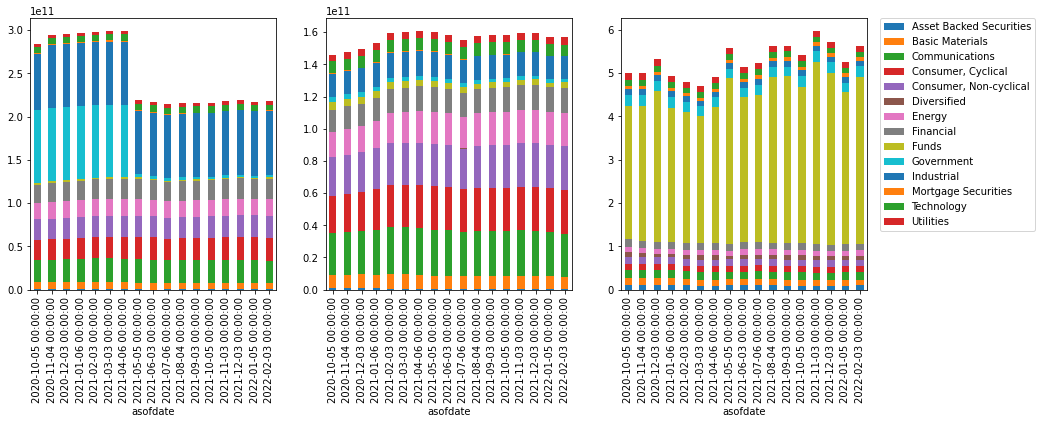

In [473]:
num_shares = holding_df.groupby(['asofdate', 'INDUSTRY_SECTOR'])['numberofshare'].sum().reset_index()
num_shares = num_shares.pivot(index='asofdate', columns='INDUSTRY_SECTOR', values='numberofshare')

market_value = holding_df.groupby(['asofdate', 'INDUSTRY_SECTOR'])['marketvalue'].sum().reset_index()
market_value = market_value.pivot(index='asofdate', columns='INDUSTRY_SECTOR', values='marketvalue')

weight = holding_df.groupby(['asofdate', 'INDUSTRY_SECTOR'])['weighting'].mean().reset_index()
weight = weight.pivot(index='asofdate', columns='INDUSTRY_SECTOR', values='weighting')

fig, axs = plt.subplots(1,3,figsize=(15,5))
num_shares.plot(kind='bar',stacked = True,  ax = axs[0])
market_value.plot(kind='bar', stacked=True, ax = axs[1])
weight.plot(kind='bar', stacked = True, ax = axs[2])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# 3. Modeling the data 

what we care about are security type rating, industry sector and the industry group.

In [ ]:
# rtg_MOODY has '#N/A Field Not Applicable' as nans 
#pd.unique(df.RTG_MOODY)

# rtg_sp has '#N/A Field Not Applicable' as nans 
#pd.unique(df.RTG_SP)

# security type column has np.nan
#pd.unique(df.SECURITY_TYP)

# industry group column has np.nan
#pd.unique(df.INDUSTRY_GROUP)

# INDUSTRY_SECTOR has no NA's
#pd.unique(df.INDUSTRY_SECTOR)

In [507]:
# American Funds American High-Inc A does not have monthly return data 
monthly_return_df = pd.read_excel('data/fund_cusip_monthly.xlsx', index_col = 0)
monthly_return_df.drop(monthly_return_df.filter(regex='Unnamed').columns, axis=1, inplace = True)
monthly_return_df.drop(monthly_return_df[monthly_return_df['asofdate'] < '2020-10-01'].index, inplace = True)
monthly_return_df.rename(columns={'CUST_TRR_RETURN_HOLDING_PER':'CUST_TRR_RETURN_HOLDING_PER_monthly'}, inplace = True)
monthly_return_df.replace('#N/A Invalid Security', np.nan, inplace = True)
monthly_return_df['CUST_TRR_RETURN_HOLDING_PER_monthly'] = monthly_return_df['CUST_TRR_RETURN_HOLDING_PER_monthly'].astype('float')
monthly_return_df['cusip'] = monthly_return_df['cusip'].astype('string')
print(monthly_return_df.dtypes)
monthly_return_df.head(3)

cusip                                          string
asofdate                               datetime64[ns]
CUST_TRR_RETURN_HOLDING_PER_monthly           float64
dtype: object


,cusip,asofdate,CUST_TRR_RETURN_HOLDING_PER_monthly
7598,77958B204,2020-10-05,-0.408007
12107,74440Y108,2020-10-05,-0.127205
30551,957663636,2020-10-05,-0.468611


In [511]:
model_df = df.merge(monthly_return_df, how = 'left', on = ['cusip', 'asofdate']).drop(columns = ['year', 'mon', 'universe', 'id',  'isin', 'securityname', 'CUSIP_hold', 'numberofshare', 'marketvalue', 'RTG_SP',  'CUST_TRR_RETURN_HOLDING_PER'])

In [405]:
wide_data_list = []
for col in ['RTG_MOODY', 'SECURITY_TYP', 'INDUSTRY_SECTOR', 'INDUSTRY_GROUP']:
    b = (model_df[['asofdate', 'name', 'weighting', col]]
    .groupby(['asofdate', 'name', col])['weighting'].sum()
    .reset_index()
    .rename(columns = {'weighting':'total_weighting'})
    .pivot(index =['asofdate', 'name'], columns = col, values = 'total_weighting').reset_index()
    .sort_values(['asofdate', 'name']))
    wide_data_list.append(b)

model_df_wide = pd.concat(wide_data_list, axis = 1)
model_df_wide = model_df_wide.loc[:,~model_df_wide.columns.duplicated()]
model_df_wide = (model_df_wide
    .merge(model_df[['asofdate', 'name', 'CUST_TRR_RETURN_HOLDING_PER_monthly']].drop_duplicates(), how = 'left', on =['asofdate','name']))


model_df_wide = model_df_wide[model_df_wide['CUST_TRR_RETURN_HOLDING_PER_monthly'].notna()]
model_df_wide.head(5)

Empty DataFrame
Columns: [asofdate, name, #N/A Field Not Applicable, A2, A3, Aa1, Aa2, Aa3, Aaa, B1, B1 *+, B1 *-, B1u, B2, B2 *+, B2 *-, B2u, B2u *+, B3, B3 *+, B3 *-, B3u, Ba1, Ba1 *+, Ba1 *-, Ba1u, Ba2, Ba2 *+, Ba2 *-, Ba2u, Ba3, Ba3 *+, Ba3 *-, Ba3u, Baa1, Baa1 *-, Baa2, Baa2 *+, Baa2 *-, Baa3, Baa3 *+, Baa3 *-, Baa3u, C, Ca, Ca *+, Caa1, Caa1 *+, Caa1 *-, Caa1u, Caa2, Caa2 *+, Caa2 *-, Caa2u, Caa3, Caa3 *+, Caa3 *-, Caa3u, Cu, NR, WR, ABS Auto, ABS Home, ABS Other, ADR, Agncy CMBS, CANADIAN, CF, CMBS, Common Stock, DELAY-DRAW TERM, DOMESTIC, DOMESTIC MTN, ETP, EURO MTN, EURO NON-DOLLAR, EURO-DOLLAR, EURO-ZONE, Equity WRT, FIXED, FIXED, OID, GLOBAL, MLP, Misc., NY Reg Shrs, Open-End Fund, PIK TERM, PRIV PLACEMENT, PRIVATE, PUBLIC, Private Comp, Prvt CMO FLT, Prvt CMO IO, Prvt CMO Other, REIT, TERM, US DOMESTIC, US GOVERNMENT, Unit, YANKEE, ...]
Index: []

[0 rows x 197 columns]


,asofdate,name,#N/A Field Not Applicable,A2,A3,Aa1,Aa2,Aa3,Aaa,B1,...,Sovereign,Storage/Warehousing,Telecommunications,Textiles,Toys/Games/Hobbies,Transportation,Trucking&Leasing,WL Collateral CMO,Water,CUST_TRR_RETURN_HOLDING_PER_monthly
0,2020-10-05,AB High Income Advisor,0.44,0.02,0.18,0.02,0.22,0.01,8.49,5.52,...,19.8,NaN,2.60,NaN,0.03,0.43,0.03,7.89,NaN,-0.675205
2,2020-10-05,BlackRock High Yield Bond Instl,4.10,0.00,0.42,0.00,NaN,NaN,NaN,11.99,...,NaN,NaN,7.06,NaN,0.24,0.04,0.01,NaN,NaN,-0.004094
3,2020-10-05,Columbia High Yield Bond A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.42,...,NaN,NaN,7.44,NaN,0.37,0.17,NaN,NaN,NaN,-0.435780
4,2020-10-05,Federated Hermes Instl High Yield Bd IS,8.34,NaN,NaN,NaN,NaN,NaN,NaN,10.45,...,NaN,NaN,2.91,NaN,NaN,0.17,NaN,NaN,NaN,-0.225844
8,2020-10-05,Goldman Sachs High Yield Instl,0.00,0.00,0.00,NaN,NaN,NaN,NaN,10.59,...,NaN,0.11,6.81,NaN,0.30,0.10,0.00,NaN,NaN,-0.681836
